https://colab.research.google.com/drive/1G2vjIkEzhZRnZ0xhUudi6VAma2HIpkG_#scrollTo=lmeRTeIIH7Kl

In [ ]:
%%capture
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)
!pip install torch_snippets
from torch_snippets import *

In [ ]:
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.utils import make_grid
from torchvision.io import read_image

### Загрузим датасет

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kostyasereginmailru","key":"ad05ad97cdde449caa2e57874c5b2819"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 75 Aug  8 17:12 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces

 98% 433M/441M [00:08<00:00, 75.4MB/s]
100% 441M/441M [00:08<00:00, 54.2MB/s]


In [ ]:
!unzip -qq /content/anime-faces.zip



---



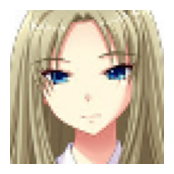

(None, (64, 64))

In [ ]:
show('/content/data/data/10000.png',sz=2), read('/content/data/data/10000.png').shape

In [ ]:
def to_DataFrame_1200_pics(way):
  data_image_paths = [str(i) for i in Glob(f'{way}/*.png')]
  data ={'way': data_image_paths}
  df = pd.DataFrame(data)
  df = df.sample(1200)
  return df

df = to_DataFrame_1200_pics('/content/data/data')

In [ ]:
df.shape

(1200, 1)

In [ ]:
df.head(4)

,way
12388,/content/data/data/15941.png
2466,/content/data/data/9412.png
8355,/content/data/data/442.png
5096,/content/data/data/12309.png


In [ ]:
transform=transforms.Compose([
#                               transforms.Resize(64),
#                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
list(df.iloc[:,0])

In [ ]:
class Faces(Dataset):
    def __init__(self, df):
        super().__init__()
        self.images = list(df.iloc[:,0])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [ ]:
ds = Faces(df=df)

In [ ]:
ds

In [ ]:
for i in ds:
  print(i,i.shape)
  break

tensor([[[ 1.0000,  0.9922,  0.9294,  ...,  0.8196,  0.8902,  0.5922],
         [ 0.9843,  0.9765,  0.8039,  ...,  0.8196,  0.8588,  0.7333],
         [ 0.9922,  1.0000,  0.7961,  ...,  0.8353,  0.8353,  0.7961],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  0.5843,  1.0000,  0.9529],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.9059,  0.9529,  0.9373],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8510,  1.0000,  0.9843]],

        [[ 1.0000,  1.0000,  0.9137,  ...,  0.5294,  0.6627,  0.2314],
         [ 0.9843,  0.9843,  0.8039,  ...,  0.5451,  0.6314,  0.4118],
         [ 0.9922,  1.0000,  0.7804,  ...,  0.5922,  0.5765,  0.4667],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  0.4118,  0.9922,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8275,  0.9686,  0.9922],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8353,  0.9843,  0.9922]],

        [[ 0.9922,  1.0000,  0.8745,  ...,  0.0039,  0.1529, -0.2078],
         [ 0.9843,  0.9686,  0.6627,  ...,  0.0196,  0.1294, -0.0588],
         [ 1.0000,  0.9608,  0.5529,  ...,  0.0588,  0.0824, -0.0118],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  0.1294,  1.0000,  0.9843],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8510,  0.9216,  0.9765],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8275,  0.9843,  0.9765]]])
torch.Size([3, 64, 64])

In [ ]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True)



---



**Блок выводит картинки в удобной форме**

In [ ]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    for images in dl:
        show_images(images, nmax)
        break

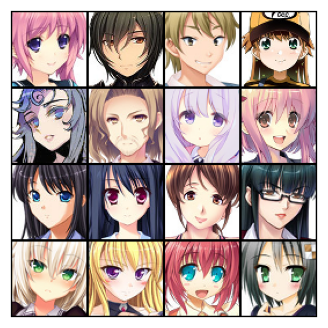

In [ ]:
show_batch(dataloader)



---



In [ ]:
for i in dataloader:
  print(i)
  break

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)

In [ ]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

EPOCH: 1.000  d_loss: 0.340  g_loss: 7.184  (2.14s - 1069.10s remaining)
EPOCH: 2.000  d_loss: 0.129  g_loss: 13.824  (4.15s - 1032.94s remaining)
EPOCH: 3.000  d_loss: 1.118  g_loss: 16.539  (6.19s - 1025.47s remaining)
EPOCH: 4.000  d_loss: 1.593  g_loss: 13.582  (8.29s - 1027.41s remaining)
EPOCH: 5.000  d_loss: 1.045  g_loss: 11.499  (10.63s - 1052.24s remaining)
EPOCH: 6.000  d_loss: 0.791  g_loss: 9.066  (12.72s - 1047.00s remaining)
EPOCH: 7.000  d_loss: 0.561  g_loss: 6.463  (14.73s - 1037.35s remaining)
EPOCH: 8.000  d_loss: 0.624  g_loss: 7.711  (17.03s - 1047.55s remaining)
EPOCH: 9.000  d_loss: 0.588  g_loss: 6.687  (19.03s - 1038.15s remaining)
EPOCH: 10.000  d_loss: 0.663  g_loss: 7.905  (21.08s - 1033.00s remaining)
EPOCH: 11.000  d_loss: 0.719  g_loss: 7.792  (23.39s - 1039.82s remaining)
EPOCH: 12.000  d_loss: 0.678  g_loss: 7.390  (25.46s - 1035.44s remaining)
EPOCH: 13.000  d_loss: 0.668  g_loss: 6.737  (27.52s - 1030.88s remaining)
EPOCH: 14.000  d_loss: 0.640  g_lo

100%|██████████| 601/601 [00:01<00:00, 473.39it/s]


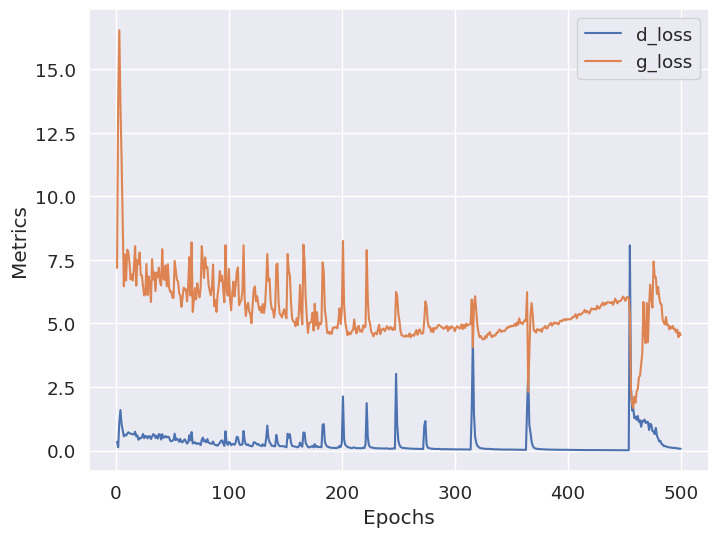

In [ ]:
log = Report(500)
for epoch in range(500):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

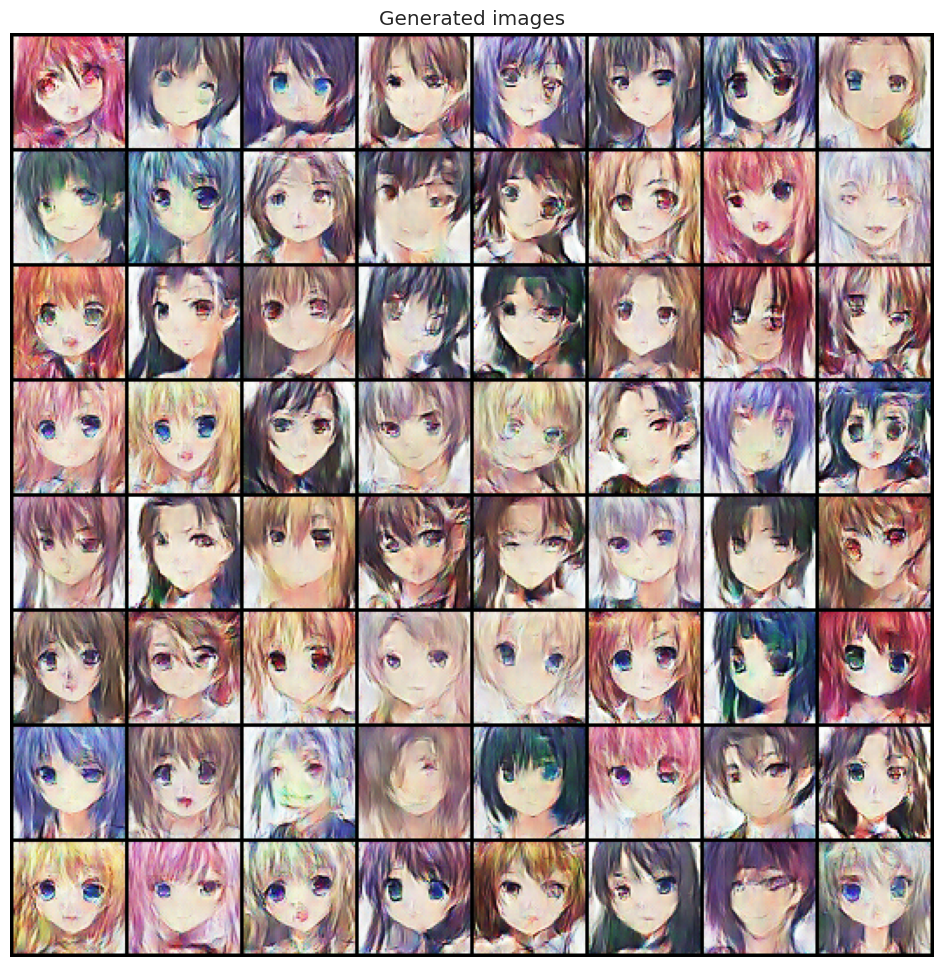

In [ ]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=12, title='Generated images')

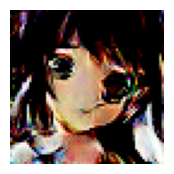

In [ ]:
show(sample_images[12],sz=2)

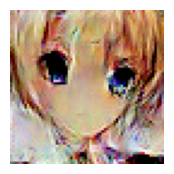

In [ ]:
show(sample_images[44],sz=2)